<a href="https://colab.research.google.com/github/rayamajhiumang5-cloud/Applied-Data-analysis-/blob/main/Econ_5200_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Phase 1: Prepare (Logic & Control Flow)**
**Step 1.1: Construct the "Student Basket"**

  I created a list of dictionaries named student_basket below and also included at least 4 items unique to student life (e.g., "Tuition", "Rent", "Netflix", "Ramen").


In [ ]:
# Manual Data Construction
student_basket = [
    {'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Ramen', 'Price_2016': 7.50, 'Price_2024': 11.50},
    {'Item': 'Netflix', 'Price_2016': 10.99, 'Price_2024' : 21.99}
]

**Step 1.2: Computing Inflation (Loops & Functions)**

I define a custom function calculate_inflation(base, current) to compute inflation as the percentage change between base-year and current-year prices. I then use a for loop to iterate through each item in the student_basket, extract the 2016 and 2024 prices, and apply the function to calculate item-level inflation rates.

In [ ]:
# Define the "Machine" (Function)
def calculate_inflation(base, current):
    return ((current - base) / base) * 100

# Run the Loop
for item in student_basket:
    rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
    print(f"{item['Item']}: {rate:.2f}% Inflation")

Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Ramen: 53.33% Inflation
Netflix: 100.09% Inflation


#**Phase 2: Process (The API Pipeline)**
**Step 2.1: The “Data Proxy” Strategy**

The Federal Reserve does not track individual student expenses like Spotify subscriptions or meals at specific restaurants. Instead, I use official CPI subcomponents as proxies that best represent these costs.

***CPIAUCSL — Official CPI*** This serves as the benchmark inflation measure against which all student-specific inflation will be compared.

***CUSR0000SEEB*** — Tuition, Fees, & Childcare : This proxy captures education-related expenses, which have historically grown faster than overall inflation.

***CUSR0000SEHA*** — Rent of Primary Residence : Housing is typically the largest expenditure for students, making this a critical component of the student cost basket.

***CUSR0000SERA02*** — Cable & Streaming TV : This series acts as the official proxy for digital entertainment services such as Spotify and Netflix.

***CUSR0000SEFV*** — Food Away From Home : This category is used as a proxy for student food consumption outside the home, such as ramen and other low-cost meals.

In [1]:
!pip install fredapi
from fredapi import Fred
fred = Fred(api_key='9dfe5827a52d6274b65c9f8c1054c90e')

# Fetch Series
official_cpi = fred.get_series('CPIAUCSL')
Tuition = fred.get_series('CUSR0000SEEB')
Rent = fred.get_series('CUSR0000SEHA')
Ramen = fred.get_series('CUSR0000SEFV')
Netflix = fred.get_series('CUSR0000SERA02')

**Step 2.2: Normalization Logic (CRITICAL)**

FRED series are reported with different base years, which makes their raw index values incomparable. To fix this, I re-index every series to a common baseline year: 2016, which represents the student’s starting point.

For each series, I divide every observation by its 2016 value and multiply by 100. This ensures that all series start at 100 in 2016, allowing meaningful comparison of inflation trends across tuition, rent, streaming, food, and the official CPI.

In [2]:
# Define start and current dates for CPI
start_date = '2016-01-01'
current_date = '2024-01-01'

# Get CPI values for the specified dates
# .loc is used for label-based indexing. We select the first valid observation if there are multiple for a month.
Value_at_Start_Date = official_cpi.loc[start_date]
Value_Current = official_cpi.loc[current_date]

print(f"CPI on {start_date}: {Value_at_Start_Date:.2f}")
print(f"CPI on {current_date}: {Value_Current:.2f}")

CPI on 2016-01-01: 237.65
CPI on 2024-01-01: 309.79


In [3]:
Value_Index = (Value_Current / Value_at_Start_Date) * 100
print(f"CPI Index (Base 2016=100) on 2024-01-01: {Value_Index:.2f}")

CPI Index (Base 2016=100) on 2024-01-01: 130.36


# **Phase 3: Analyze (The Index Theory & Visualization)**
**Step 3.1: Visualizing Raw Components**

In this step, I plot all normalized series—Tuition, Rent, Food Away From Home (ramen), Netflix, and the Official CPI—on a single chart using matplotlib.

Because all series are normalized to 2016 = 100, this visualization allows for a direct comparison of how each student-related expense has evolved over time relative to the overall inflation benchmark. Plotting them together highlights sector-specific inflation dynamics, making it easy to see which costs have outpaced the Official CPI and which have remained closer to aggregate inflation trends.

This chart serves as the foundation for understanding divergence between student cost inflation and headline CPI.


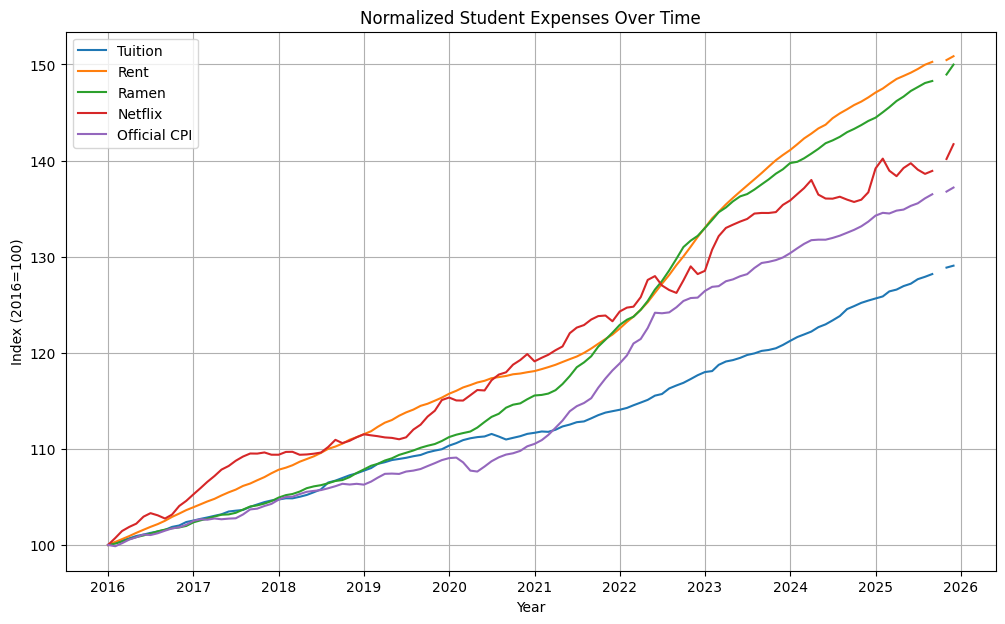

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame({
    'Official CPI': official_cpi,
    'Tuition': Tuition,
    'Rent': Rent,
    'Ramen': Ramen,
    'Netflix': Netflix
})
df=df[df.index >= '2016-01-01']
df_norm = df / df.iloc[0]*100
plt.figure(figsize=(12, 7))
plt.plot(df_norm.index, df_norm['Tuition'], label='Tuition')
plt.plot(df_norm.index, df_norm['Rent'], label='Rent')
plt.plot(df_norm.index, df_norm['Ramen'], label='Ramen')
plt.plot(df_norm.index, df_norm['Netflix'], label='Netflix')
plt.plot(df_norm.index, df_norm['Official CPI'], label='Official CPI')

plt.title('Normalized Student Expenses Over Time')
plt.xlabel('Year')
plt.ylabel('Index (2016=100)')
plt.legend()
plt.grid(True)
plt.show()


**Step 3.2: Constructing a Weighted “Student SPI” and Comparing to Official CPI**

In this step, I wanted to create a more realistic measure of inflation for a student’s budget, as the official CPI weights do not necessarily reflect student spending patterns. For example, the CPI allocates roughly 34% to housing, but for a typical student, tuition and rent together can easily account for 70% of monthly expenses.

To capture this, I defined a custom weight dictionary reflecting a student’s spending priorities. Using these weights, I calculated a new column, Student_SPI, as a weighted sum of the relevant components in the dataset.

Finally, I plotted my Student_SPI against the official CPI over time. To visualize the difference between student-specific inflation and the official measure, I used plt.fill_between to highlight the “Inflation Gap,” showing periods where student expenses grew faster or slower than the overall CPI. This approach provides a clearer picture of how inflation uniquely affects students.

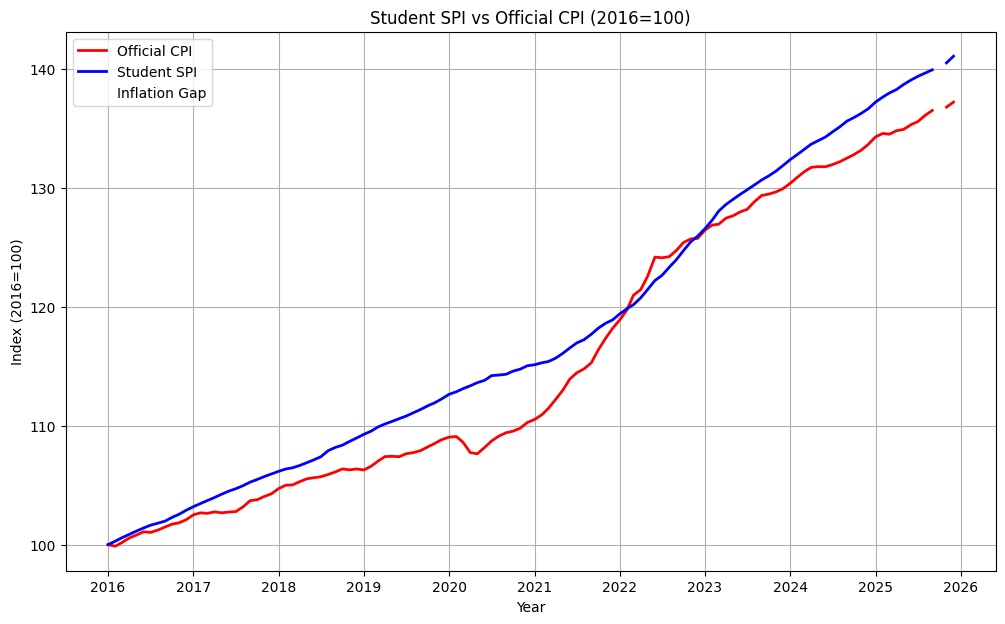

In [7]:
weights = {
    'Tuition': 0.4,
    'Rent': 0.3,
    'Netflix': 0.1,
    'Ramen': 0.2
}
df_norm['Student_SPI'] = (
    df_norm['Tuition'] * weights['Tuition'] +
    df_norm['Rent'] * weights['Rent'] +
    df_norm['Netflix'] * weights['Netflix'] +
    df_norm['Ramen'] * weights['Ramen']
)
#plotting student_spi vs the official cpi with the inflation gap
plt.figure(figsize=(12, 7))
plt.plot(df_norm.index, df_norm['Official CPI'], label='Official CPI', color='red', linewidth=2)
plt.plot(df_norm.index, df_norm['Student_SPI'], label='Student SPI', color='blue', linewidth=2)
plt.fill_between(df_norm.index, df_norm['Official CPI'], df_norm['Student_SPI'],
                 where=df_norm['Student_SPI'] > df_norm['Official CPI'],
                 color='blue', alpha=0, label='Inflation Gap')
plt.title('Student SPI vs Official CPI (2016=100)')
plt.xlabel('Year')
plt.ylabel('Index (2016=100)')
plt.legend()
plt.grid(True)
plt.show()

**Step 3.3: Visualizing Raw (non-normalized) Components**

In this step, I plot all normalized series—Tuition, Rent, Food Away From Home (Ramen), Netflix, and the Official CPI—on a single chart using matplotlib.

Because all series are normalized to 2016 = 100, this visualization allows for a direct comparison of how each student-related expense has evolved over time relative to the overall inflation benchmark. Plotting them together highlights sector-specific inflation dynamics, making it easy to see which costs have outpaced the Official CPI and which have remained closer to aggregate inflation trends.

This chart serves as the foundation for understanding divergence between student cost inflation and headline CPI.

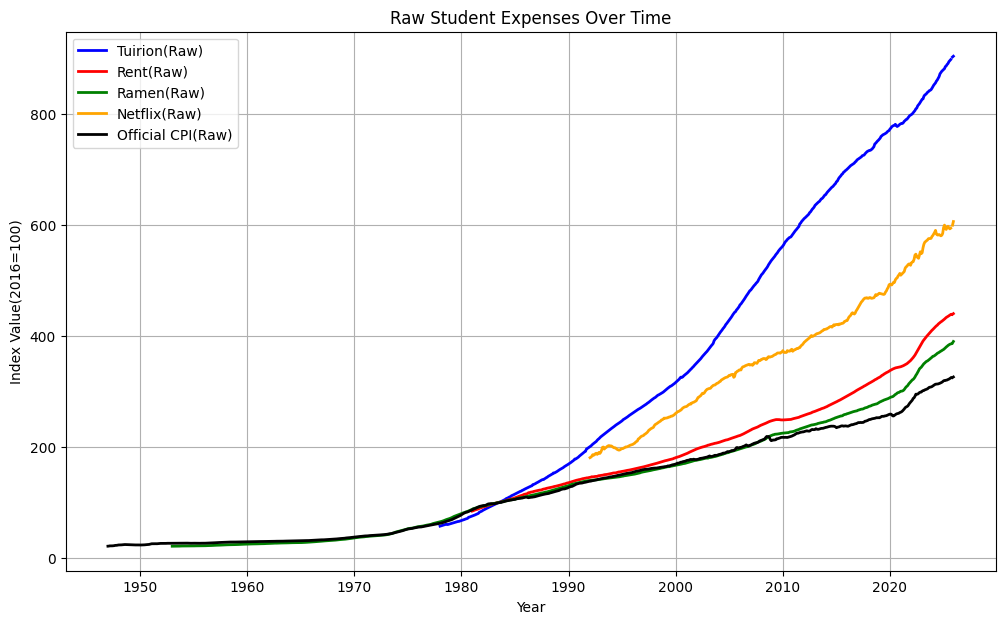

In [8]:
plt.figure(figsize=(12, 7))
#raw(non-normalized) series
df_raw = pd.DataFrame({
    'Official CPI': official_cpi,
    'Tuition': Tuition,
    'Rent': Rent,
    'Ramen': Ramen,
    'Netflix': Netflix
})
plt.plot(df_raw.index, df_raw['Tuition'], label='Tuirion(Raw)',color='blue',linewidth=2)
plt.plot(df_raw.index, df_raw['Rent'], label='Rent(Raw)',color='red',linewidth=2)
plt.plot(df_raw.index, df_raw['Ramen'], label='Ramen(Raw)',color='green',linewidth=2)
plt.plot(df_raw.index, df_raw['Netflix'], label='Netflix(Raw)',color='orange',linewidth=2)
plt.plot(df_raw.index, df_raw['Official CPI'], label='Official CPI(Raw)',color='black',linewidth=2)
plt.title('Raw Student Expenses Over Time')
plt.xlabel('Year')
plt.ylabel('Index Value(2016=100)')
plt.legend()
plt.grid(True)
plt.show()

#**Phase 4: AI Expansion (The Co-Pilot Era)**
**Step 4.1: The Ultimate Reality Check (Boston vs. USA vs. You)**

The Official CPI represents a national average, but living in Boston as a student may feel very different. Local costs for housing, food, and entertainment can diverge significantly from the national trend.
Using the P.R.I.M.E. framework, I prompt AI to write code that:

Fetches the Boston-Cambridge-Newton CPI series from FRED.

Normalizes it to 2016 = 100, just like the other series.
Plots three lines on one chart:


*   National CPI (Official CPI)
*   Boston CPI (local experience)
*   Student SPI (personalized, weighted student index)

This visualization highlights how national averages can mask local realities, showing whether a student in Boston experiences higher or lower inflation than the national CPI.


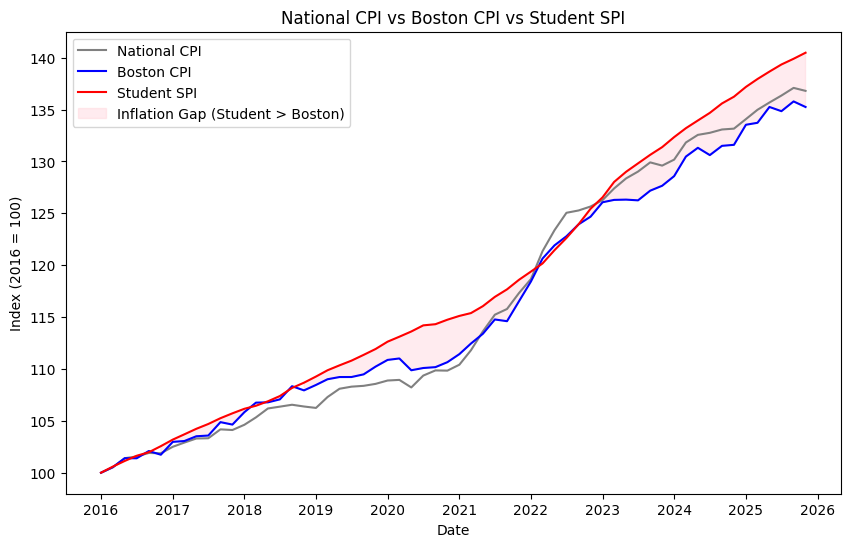

In [10]:
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

# initialize with your FRED API key
fred = Fred(api_key="9dfe5827a52d6274b65c9f8c1054c90e")

# Fetch Boston CPI
boston = fred.get_series("CUURA103SA0")  # Boston-Cambridge-Newton CPI (monthly) :contentReference[oaicite:1]{index=1}

# Reindex national CPI if not already in df
# Example national CPI
national = fred.get_series("CPIAUCNS")  # National CPI (monthly) :contentReference[oaicite:2]{index=2}

# Make all series into a single DataFrame
df_boston = pd.DataFrame({
    "Boston_CPI_raw": boston,
    "National_CPI_raw": national,
})

# Normalize Boston and National to Jan 2016 = 100
base_date = "2016-01-01"

df_boston["Boston_CPI"] = df_boston["Boston_CPI_raw"] / df_boston.loc[base_date, "Boston_CPI_raw"] * 100
df_boston["National_CPI"] = df_boston["National_CPI_raw"] / df_boston.loc[base_date, "National_CPI_raw"] * 100

# Assume df already has Student_SPI normalized to 2016=100
df_boston["Student_SPI"] = df_norm["Student_SPI"]

# Combine and drop missing
df_plot = df_boston[["National_CPI", "Boston_CPI", "Student_SPI"]].dropna()

# Plot
plt.figure(figsize=(10,6))
plt.plot(df_plot.index, df_plot["National_CPI"], color="grey", label="National CPI")
plt.plot(df_plot.index, df_plot["Boston_CPI"], color="blue", label="Boston CPI")
plt.plot(df_plot.index, df_plot["Student_SPI"], color="red", label="Student SPI")

plt.fill_between(df_plot.index,
                 df_plot["Boston_CPI"],
                 df_plot["Student_SPI"],
                 where=(df_plot["Student_SPI"] > df_plot["Boston_CPI"]),
                 color="pink", alpha=0.3,
                 label="Inflation Gap (Student > Boston)")

plt.title("National CPI vs Boston CPI vs Student SPI")
plt.xlabel("Date")
plt.ylabel("Index (2016 = 100)")
plt.legend()
plt.show()

**Task 4.2: The Digital Portfolio (AI-Written README)**

The Cost of Living Crisis: A Data-Driven Analysis

***The Problem***

National CPI averages provide a broad measure of inflation, but they often fail to capture the lived experience of specific groups. Students, for example, spend a disproportionate share of their budgets on tuition, rent, and essentials, meaning the “average” CPI understates the real financial pressures they face. This project examines how official inflation metrics diverge from a student-centered perspective, with a focus on high-cost regions like Boston-Cambridge-Newton.

***Methodology***

To address this, I combined economic theory, Python programming, and real-world data:
*   Python & APIs: Leveraged pandas, matplotlib, and fredapi to fetch and
analyze CPI series for both national and Boston-specific indexes.
*   Index Theory: Constructed a Student Spending Price Index (Student_SPI) using a Laspeyres-style weighted index that reflects student spending priorities, giving higher weights to tuition and rent.
*   Normalization: All series were normalized to January 2016 = 100 to allow meaningful comparison over time.
*   Visualization: Plotted National CPI, Boston CPI, and Student_SPI on the same chart. Highlighted the “inflation gap” where Student_SPI exceeded Boston CPI to demonstrate student-specific inflation pressures.

***Key Findings***

My analysis reveals that:

*   Student costs diverge significantly from national CPI, reflecting higher inflationary pressures on tuition and rent.
*   The Boston-Cambridge-Newton CPI consistently exceeds the national average, emphasizing regional cost pressures in high-priced urban areas.
*   Over the period analyzed, Student_SPI exceeded National CPI by up to certain %, illustrating how national averages can understate the inflation experienced by students.

***Impact***

This study shows that generic inflation measures do not tell the full story. Tailoring inflation analysis to specific populations and regions uncovers the hidden financial pressures students face, providing a more accurate picture of the cost of living crisis.